In [1]:
# Use this code to train a new model by using combinations of the different functions appearing in the file Helper_FCN.py in the function Data_Generator.
# This code doesnt need of any precomputed files! It will generate the data during the process.

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
import Helper_FCN as HFCN #Cuaderno con funciones de ayuda

import tensorflow as tf
import scipy.io

from keras import layers
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, TerminateOnNaN, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from keras.models import Model, load_model
from keras.utils import Sequence, plot_model

from joblib import Parallel, delayed

import absl.logging
tf.get_logger().setLevel('ERROR')
absl.logging.set_verbosity(absl.logging.ERROR)

%load_ext tensorboard

In [ ]:
N_cores = 20# #Number of cores to use for parallel processing during data generation, set to -1 for all cores

epochs = 5
batch_size = 64
train_data = int(np.round((25600)/batch_size))

print("Each epoch sees " + str(train_data) + " data batches per epoch, totaling " + str(train_data * batch_size) + " data per epoch and " + str(np.round(train_data * batch_size * epochs, 2)) + " in total")

separated_orbits = True #If True, the orbits are separated in the data generation with [-1,-1] values 
mean_extension = 2000
noise_generator = HFCN.NoiseGenerator(min_value=0.001, max_value=0.1, lambda_=0.5, size=train_data) 

Each epoch sees 4 data batches per epoch, totaling 256 data per epoch and 1280 in total


In [4]:
def process_data(batch_size, test=False):
    xVectors_batch = []
    Ics_batch = []
    Us_batch = []

    y_batch = []

    loop_range = range(batch_size) if not test else range(1000) #Para hacer las predicciones de la red, 1000 ya que es la resolucion del output de la red

    for _ in loop_range:
        
        if test == False:
            y = HFCN.Function_Generator()
            xVectors, Us, Ic= HFCN.Data_Generator(y = y, ruido_max = noise_generator.get_noise(), n_series=1000, padding=50, mean_extension=mean_extension, test=test, b = _, separated_orbits=separated_orbits)
        else:
            if __ == 0:
                y = HFCN.Function_Generator()
                noise = noise_generator.get_noise()

            xVectors, Us, Ic= HFCN.Data_Generator(y = y, ruido_max = noise, n_series=1000, padding=50, mean_extension=mean_extension, test=test, b = _, separated_orbits=separated_orbits)

        xVectors_batch.append(xVectors)
        Ics_batch.append(Ic)
        Us_batch.append(Us)
        y_batch.append(y)

    xVectors_batch = np.array(xVectors_batch)
    Ics_batch = np.array(Ics_batch)
    Us_batch = np.array(Us_batch)
    y_batch = np.array(y_batch)

    #Normalizacion del batch
    #xVectors_batch =  (xVectors_batch - np.min(xVectors_batch)) / (np.max(xVectors_batch) - np.min(xVectors_batch))
    Ics_batch = Ics_batch/1000
    #Us_batch = (Us_batch - np.min(Us_batch)) / (np.max(Us_batch) - np.min(Us_batch))

    return [np.array(xVectors_batch), np.array(Ics_batch)], [np.array(Us_batch), np.array(y_batch)]

In [5]:
class CustomDataGenerator(Sequence):
    def __init__(self, data, batch_size, test=False):
        self.data = data
        results = Parallel(n_jobs=-1)(delayed(process_data)(batch_size, test=False) for _ in range(self.data))
        self.x = np.concatenate([result[0][0] for result in results])
        self.Ics = np.concatenate([result[0][1] for result in results])
        self.y = np.concatenate([result[1][0] for result in results])
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_Ics = self.Ics[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

        return [np.array(batch_x), np.array(batch_Ics)], [np.array(batch_y)]

    def on_epoch_end(self):
        del self.x, self.y
        results = Parallel(n_jobs=-1)(delayed(process_data)(batch_size, test=False) for _ in range(self.data))
        self.x = np.concatenate([result[0][0] for result in results])
        self.Ics = np.concatenate([result[0][1] for result in results])
        self.y = np.concatenate([result[1][0] for result in results])

train_set = CustomDataGenerator(train_data, batch_size, test=False)

In [6]:
# Define the MirroredStrategy in case there are multiple GPUs available 
# https://www.tensorflow.org/guide/distributed_training

strategy = tf.distribute.MirroredStrategy(devices=["/GPU:0", "/GPU:1"], cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())
with strategy.scope():

    input_1 = layers.Input(shape=(mean_extension, 2), name='input_1')
    input_2 = layers.Input(shape=(1,), name='input_2')
    repeated_input_2 = layers.RepeatVector(mean_extension)(input_2) # Repeat the input_2 tensor to match the shape of input_1

    x_input = layers.concatenate([input_1, repeated_input_2], axis=-1)

    # Block 1 Attention block

    x = layers.MultiHeadAttention(key_dim=256, num_heads=4, dropout=0.05)(x_input, x_input)
    res = layers.Add()([x, x_input])

    x = layers.Conv1D(filters=1024, kernel_size=1, activation="relu")(res)
    x = layers.Conv1D(filters=x_input.shape[-1], kernel_size=1)(x)
    xn = layers.Add()([x, res])

    #Block 2 Attention block
    
    x = layers.MultiHeadAttention(key_dim=256, num_heads=4, dropout=0.05)(xn, xn)
    res = layers.Add()([x, xn])

    x = layers.Conv1D(filters=1024, kernel_size=1, activation="relu")(res)
    x = layers.Conv1D(filters=x_input.shape[-1], kernel_size=1)(x)
    xn = layers.Add()([x, res])

    #Block 3 Conv Block

    x = layers.Conv1D(filters=512, kernel_size=7, activation="relu")(xn)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv1D(filters=512, kernel_size=3, activation="relu")(x)
    x = layers.Dropout(0.2)(x)

    #Block 4  Global Max and Average Pooling

    x_max = layers.GlobalMaxPooling1D()(x)
    x_avg = layers.GlobalAveragePooling1D()(x)
    x = layers.concatenate([x_max, x_avg]) 

    # Block 5 Output Block

    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(1, activation='linear', name='output')(x)

    # Define the model
    model = Model(inputs=[input_1, input_2], outputs=x, name=str(mean_extension) + '_input_model')

    loss = 'mse'
    metrics = 'mse'

    learning_rate = 0.00015
    final_lr = 0.000030

    warmup_epochs = 6
    decay_factor =  final_lr/learning_rate
    lr_schedule = LearningRateScheduler(lambda epoch, lr: HFCN.lr_warmup_scheduler(epoch, lr, learning_rate, warmup_epochs, epochs, decay_factor))

    optimizer = Adam(learning_rate=learning_rate)
        
    model.compile(optimizer=optimizer, loss=HFCN.AsymmetricMSELoss(underestimation_weight=10), metrics=metrics)
    model.summary()

Model: "2000_input_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 2000, 2)]    0           []                               
                                                                                                  
 repeat_vector (RepeatVector)   (None, 2000, 1)      0           ['input_2[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 2000, 3)      0           ['input_1[0][0]',                
                                                                  'repeat_vector[0]

In [7]:
checkpoint_path = 'results/'

model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='loss', verbose=1, save_best_only=True) # Checkpoint route to be defined
tensorboard = TensorBoard(log_dir = checkpoint_path, histogram_freq=1, write_graph=False, write_images=False) # Log dir to be defined
#early_stop = EarlyStopping('loss', patience=100, verbose=1)
terminate = TerminateOnNaN()
#reduce_LR_stagnate = ReduceLROnPlateau(monitor='mse', factor=0.8, patience=100, min_lr=0.0001)

callbacks = [tensorboard, model_checkpoint, terminate, lr_schedule]

In [ ]:
history = model.fit(train_set, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    steps_per_epoch = train_data,
                    callbacks=callbacks)
        
model.save(checkpoint_path+'modellast.h5')
np.save(checkpoint_path+'history1.npy',history.history) 

"\nhistory = model.fit(train_set, \n                    epochs=epochs, \n                    batch_size=batch_size, \n                    steps_per_epoch = train_data,\n                    callbacks=callbacks)\n        \nmodel.save(checkpoint_path+'modellast.h5')\nnp.save(checkpoint_path+'history1.npy',history.history) \n"

In [ ]:
#model.load_weights(r'Models\2000\epochs_500_batch_size_64modellast.h5')

(1000, 2000, 2) (1000,) (1000,) (1000,)
32/32 [==============================] - 3s 63ms/step


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


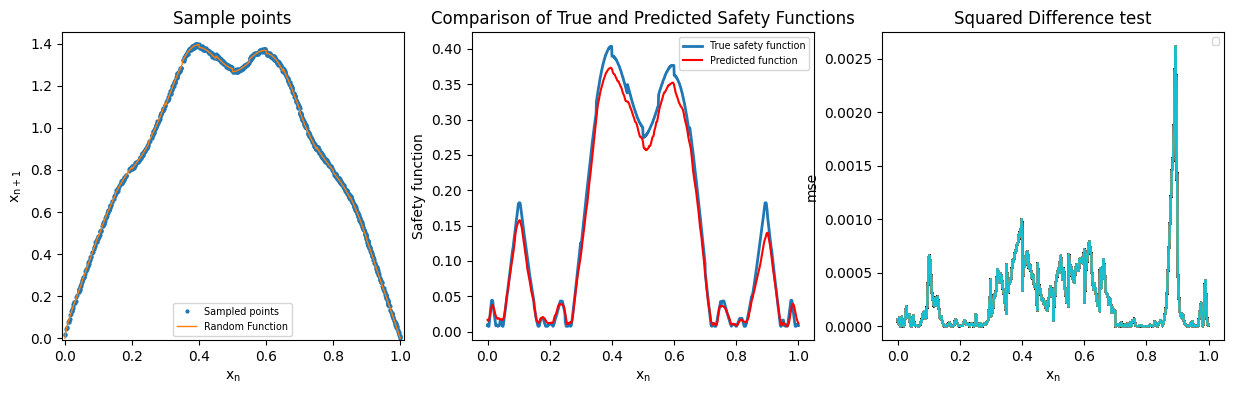

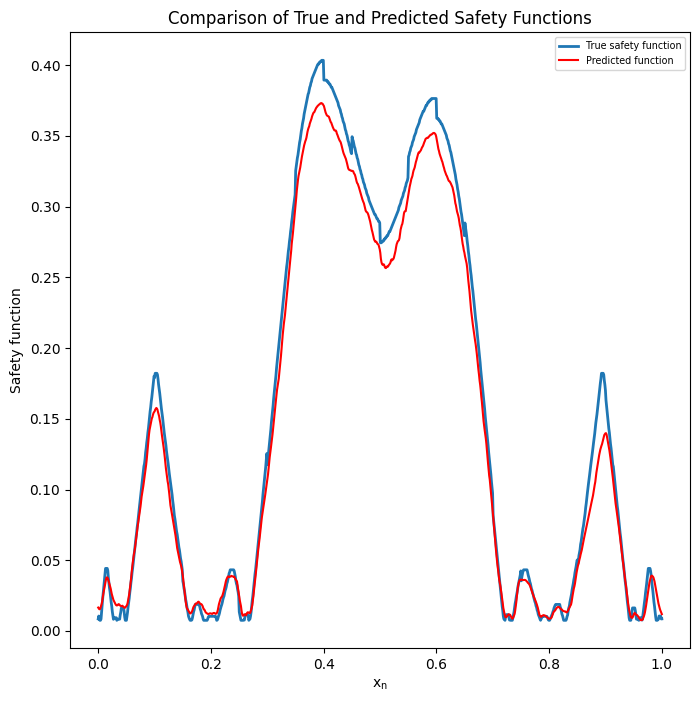

In [17]:
# Define the function to be executed in parallel
def Parallel_Data_Test(_, y, noise, n_series=1000, padding=50, mean_extension=2000, test=True, separated_orbits=True):
    xVectors, Us, Ic = HFCN.Data_Generator(y=y,ruido_max=noise,n_series=n_series,padding=padding,mean_extension=mean_extension,test=test,b=_,separated_orbits=separated_orbits)
    return xVectors, Us, Ic

y = HFCN.Function_Generator()
noise = noise_generator.get_noise()

# Use Parallel and delayed for parallel execution
test_results = Parallel(n_jobs=N_cores)(delayed(Parallel_Data_Test)(_, y, noise, n_series=1000, padding=50, mean_extension=2000, test=True, separated_orbits=True) for _ in range(1000))
xVectors_0, Us_0, ICs_0 = zip(*test_results)

xVectors = np.array(xVectors_0)
ICs = np.array(ICs_0)/1000
Us = np.array(Us_0)

print(xVectors.shape, ICs.shape, Us.shape, y.shape)

#test_pred = model.predict([xVectors, ICs])
test_pred = model.predict([np.tile(xVectors[0][np.newaxis, :, :], (1000, 1, 1)), ICs]) #So that all the initial conditions are predicted over the same samples 

# Adjusting plot settings for better appearance
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

# First subplot (ax1)

ax1.plot(xVectors[0, :, 0], xVectors[0, :, 1], '.', markersize=4,  label='Sampled points')
ax1.plot(np.linspace(0,1,1000), y, label='Random Function', linewidth=1)
ax1.axis([-0.01, 1.01, -0.01, 1 + (np.max(xVectors) - 0.95)])
ax1.set_title('Sample points', fontsize=12)
ax1.set_xlabel('$\mathrm{x_{n}}$', fontsize=10)
ax1.set_ylabel('$\mathrm{x_{n+1}}$', fontsize=10)
ax1.legend(loc='best', fontsize='x-small')
#ax1.grid(True)

# Second subplot (ax2)
ax2.plot(np.linspace(0, 1, 1000), Us, label='True safety function', linewidth=2)
ax2.plot(np.linspace(0, 1, 1000), test_pred, label='Predicted function', color='red', linewidth=1.5)

ax2.set_title('Comparison of True and Predicted Safety Functions', fontsize=12)
ax2.set_xlabel('$\mathrm{x_{n}}$', fontsize=10)
ax2.set_ylabel('Safety function', fontsize=10)
ax2.legend(loc='best', fontsize='x-small')

# Third subplot (ax3)
for i in range(len(test_pred)):
    ax3.plot(np.linspace(0, 1, 1000), (Us - test_pred.reshape(-1)) ** 2, linewidth=1.5)

ax3.set_title('Squared Difference test', fontsize=12)
ax3.set_xlabel('$\mathrm{x_{n}}$', fontsize=10)
ax3.set_ylabel('mse', fontsize=10)
ax3.legend(loc='best', fontsize='x-small')

# Adjust the layout to ensure no overlap
#plt.tight_layout()
plt.show()

# Optional: Adjust another figure if needed
plt.figure(figsize=(8, 8))
plt.plot(np.linspace(0, 1, 1000), Us, label='True safety function', linewidth=2)
plt.plot(np.linspace(0, 1, 1000), test_pred, label='Predicted function', color='red', linewidth=1.5)

plt.title('Comparison of True and Predicted Safety Functions', fontsize=12)
plt.xlabel('$\mathrm{x_{n}}$', fontsize=10)
plt.ylabel('Safety function', fontsize=10)
plt.legend(loc='best', fontsize='x-small')

# Show the figure
#plt.tight_layout()
plt.show()